<a href="https://colab.research.google.com/github/Matheus2608/Data-Science/blob/main/Projeto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto:
As culturas/plantações são vulneráveis ​​a uma variedade de doenças que levam a grandes perdas de produção no setor agrícola em todo o mundo. Para aumentar a qualidade das culturas, é de primordial importância que as plantas sejam protegidas contra quaisquer doenças potenciais. Isso também tem o efeito de reduzir o custo de produção de alimentos. Para atingir esses objetivos, as opções disponíveis incluem métodos tradicionais de identificação e diagnóstico de doenças de plantas. Isso inclui inspeções realizadas por um agricultor profissional ou o exame de uma amostra afetada no laboratório. No entanto, está claro que uma abordagem baseada em inspeção manual não é apenas demorada e cara, mas também requer um alto nível de conhecimento de domínio por um especialista. Além disso, nem todos esses métodos são particularmente precisos e, portanto, podem não conseguir diagnosticar com sucesso a doença da planta em questão. Outra solução é o uso de pesticidas durante a produção de alimentos, mas o uso de produtos químicos potencialmente nocivos leva a uma menor qualidade dos alimentos.

Para isso, um sistema automático de detecção de doenças que possa não apenas identificar o tipo de doença da planta, mas também a localização exata da lesão seria o mais adequado.

# Fazendo segmentação de instâncias de doenças em morangos

## Importando dataset do Kaggle de imagens de morangos com doenças
Para isso, eu fiz o download por linha de comando pelo dataset ser pesado. De referência segui os passos desse site: https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

Mas para isso é necessário ter uma conta no kaggle, se você não tiver sugiro que entre no link que estou fazendo o download do dataset e faça o download pra sua máquina e depois transfira para o Colab

In [ ]:
!pip install opendatasets
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/usmanafzaal/strawberry-disease-detection-dataset")

## Treinando Yolact ++
## Setup Inicial
- Para utilizar esse modelo, é necessário importar algumas bibliotecas antes


In [ ]:
# Cython precisa ser instalado antes de pycocotools
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib

#DCNv2
!pip install torchvision==0.5.0
!pip install torch==1.4.0

## Importando o código da Yolact do github dos autores dela

In [ ]:
# Clone the repo
!git clone https://github.com/dbolya/yolact.git

## DCNv2
É necessário contruir essa biblioteca, **mas** para isso é necessário que o colab esteja rodando no modo GPU

Para isso:
- Clique em Editar > COnfigurações de Notebook
- Coloque GPU como seu hardware e salve


In [ ]:
%cd /content/yolact/external/DCNv2
!python setup.py build develop

## Pesos
- Para não demorar muito o treinamento, vou usar pesos de outro modelo ja treinado
- Tentei de quase todos jeitos possíveis usando comando, mas o yolact não funciona.
- É necessário baixar o peso no github e exportar para esse colab

In [7]:
%cd /content/yolact
%mkdir weights

/content/yolact


In [ ]:
!gdown "https://drive.google.com/uc?id=15id0Qq5eqRbkD-N3ZjDZXdCvRyIaHpFB&export=download" -O "./weights/yolact_plus_base_54_800000.pth"

## Formatando a base de dados

In [ ]:
!pip install -U labelme2coco

In [2]:
%cd /content/yolact/data/

# import functions
from labelme2coco import get_coco_from_labelme_folder, save_json

# set labelme training data directory
labelme_train_folder = "/content/strawberry-disease-detection-dataset/train/"

# set labelme validation data directory
labelme_val_folder = "/content/strawberry-disease-detection-dataset/val/"

# set path for coco json to be saved
export_dir = "/content/"

# create train coco object
train_coco = get_coco_from_labelme_folder(labelme_train_folder)

# export train coco json
save_json(train_coco.json, export_dir+"train.json")

# create val coco object
val_coco = get_coco_from_labelme_folder(labelme_val_folder, coco_category_list=train_coco.json_categories)

# export val coco json
save_json(val_coco.json, export_dir+"val.json")

/content/yolact/data
There are 1450 listed files in folder .


Converting labelme annotations to COCO format: 100%|██████████| 1450/1450 [00:05<00:00, 271.45it/s]


There are 307 listed files in folder .


Converting labelme annotations to COCO format: 100%|██████████| 307/307 [00:01<00:00, 281.30it/s]


In [ ]:
# Fazendo diretório para as imagens
%cd /content/
%mkdir train_images valid_images test_images

#Transferindo as imagens dentro do dataset para o direotrio root
%cd /content/strawberry-disease-detection-dataset/train
%mv *.jpg ../../train_images/
%cd ../val/
%mv *.jpg ../../valid_images/
%cd ../test
%mv *.jpg ../../test_images/

## Agora que o dataset está formatado do jeito que é necessário, é preciso mudar o arquivo config.py eyolact.py


In [ ]:
'''
# ----------------------- DATASETS ----------------------- #
...

my_custom_dataset = dataset_base.copy({
    'name': 'Doença de Morango',

    'train_images': '/content/train_images',
    'train_info':   '/content/train.json',

    'valid_images': '/content/valid_images',
    'valid_info':   '/content/val.json',

    'has_gt': True,
    'class_names': ("Leaf Spot", "Powdery Mildew Leaf", "Gray Mold", "Anthracnose Fruit Rot", "Angular Leafspot", "Powdery Mildew Fruit", "Blossom Blight"),
    'label_map': {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7}
})

# ----------------------- CONFIG DEFAULTS ----------------------- #

coco_base_config = Config({
    'dataset': my_custom_dataset,
    'num_classes': len(my_custom_dataset.class_names) + 1, # This should include the background class,
    

# ----------------------- YOLACT++ CONFIGS ----------------------- #

yolact_plus_base_config = yolact_base_config.copy({
    'name': 'yolact_plus_base',
    'dataset': my_custom_dataset,
    'num_classes': len(my_custom_dataset.class_names) + 1,
    'backbone': resnet101_dcn_inter3_backbone.copy({
        'selected_layers': list(range(1, 4)),
        
        'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,
        'pred_scales': [[i * 2 ** (j / 3.0) for j in range(3)] for i in [24, 48, 96, 192, 384]],
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': False,
    }),

    'use_maskiou': True,
    'maskiou_net': [(8, 3, {'stride': 2}), (16, 3, {'stride': 2}), (32, 3, {'stride': 2}), (64, 3, {'stride': 2}), (128, 3, {'stride': 2})],
    'maskiou_alpha': 25,
    'rescore_bbox': False,
    'rescore_mask': True,

    'discard_mask_area': 5*5,
})
'''

#no arquivo yolact.py
'''
linha 490
try:
    self.load_state_dict(state_dict)
except RuntimeError as e:
    print('Ignoring "' + str(e) + '"')

linha 631
p = pred_layer(pred_x.detach())

'''



## Treinamento da YOLACT++

In [4]:
%cd /content/yolact/

/content/yolact


In [5]:
#PRIMEIRO TREINAMENTO
!python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_54_800000.pth  --start_iter=0

In [6]:
#SEGUNDO TREINAMENTO USANDO OS PESOS DO PRIMEIRO TREINAMENTO
!python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_5_910_interrupt.pth --save_folder checkpoint_models --start_iter=-1

In [7]:
#TERCEIRO TREINAMENTO USANDO OS PESOS DO SEGUNDO TREINAMENTO
!python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_9_1632_interrupt.pth --start_iter=-1

In [51]:
#TERCEIRO TREINAMENTO USANDO OS PESOS DO TERCEIRO TREINAMENTO
!python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_16_3024_interrupt.pth --start_iter=-1

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Resuming training, loading weights/yolact_plus_base_16_3024_interrupt.pth...
Begin training!

/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentati

#### Após Análise dos resultados do treinamento, decidi parar o treinamento pois o modelo não estava mais progredindo.
#### Os resultado do treinamento está disponível [aqui](https://github.com/Matheus2608/Data-Science/blob/main/checkpoint_model.md)


## Análise quantitativa dos resultados

In [53]:
!python eval.py --config=yolact_plus_base_config --trained_model=weights/yolact_plus_base_19_3446_interrupt.pth 

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model... Done.

Processing Images  ██████████████████████████████    307 /    307 (100.00%)    13.73 fps        
Saving data...
Calculating mAP...
Parte modificada do código por mim para obter a métrica de AP para cada classe
Lista = : [{'box': [0.9038893207577079, 0.8159049020843854, 0.8608776713199628, 0.6989520163699413, 0.9196272568433314, 0.8426884041787626, 0.9792798828755056], 'mask': [0.16720588785887974, 0.8201350583214171, 0.8433885027667729, 0.6946444644464449, 0.8810532968190437, 0.8430082110208105, 0.9878524437809628]}, {'box': [0.9029544879657606, 0.8104890020356322, 0.8424742657419672, 0.6989520163699413, 0.9196272568433314, 0.8426884041787626, 0.9792798828755056], 'mask': [0.16580223989089735, 0.8201350583214171, 0.8433885027667729, 0.6946444644464449, 0.8810532968190437, 0.8430082110208105, 0.9878524437809628]}, {'box': [0.8902406882541816, 0.797099073950559, 0.8424742657419672, 

box:
- mAP IOU 0.5 = 86.02
- mAP IOU 0.50:0.95 = 60.65

mask:
- mAP IOU 0.5 = 74.82 
- mAP IOU 0.50:0.95 = 57.11

## Cálculo da métrica AP para cada classe

In [ ]:
'''
Adicionei na linha 1017 do arquivo eval.py o seguinte comando:
print(f'Parte modificada do código por mim para obter a métrica de AP para cada classe')
print(f'Lista = : {aps}')
'''

In [54]:
lista_aps = [{'box': [0.9038893207577079, 0.8159049020843854, 0.8608776713199628, 0.6989520163699413, 0.9196272568433314, 0.8426884041787626, 0.9792798828755056], 'mask': [0.16720588785887974, 0.8201350583214171, 0.8433885027667729, 0.6946444644464449, 0.8810532968190437, 0.8430082110208105, 0.9878524437809628]}, {'box': [0.9029544879657606, 0.8104890020356322, 0.8424742657419672, 0.6989520163699413, 0.9196272568433314, 0.8426884041787626, 0.9792798828755056], 'mask': [0.16580223989089735, 0.8201350583214171, 0.8433885027667729, 0.6946444644464449, 0.8810532968190437, 0.8430082110208105, 0.9878524437809628]}, {'box': [0.8902406882541816, 0.797099073950559, 0.8424742657419672, 0.6989520163699413, 0.9196272568433314, 0.7955759861700448, 0.9792798828755056], 'mask': [0.16580223989089735, 0.8136238851344129, 0.8295662436508707, 0.6946444644464449, 0.8810532968190437, 0.799017951670989, 0.9878524437809628]}, {'box': [0.8835540137729019, 0.7871005564769742, 0.7912409692454709, 0.6989520163699413, 0.9196272568433314, 0.7955759861700448, 0.9792798828755056], 'mask': [0.1633779989150258, 0.7899372516234852, 0.8272943664704301, 0.5965775148943472, 0.860878174774, 0.799017951670989, 0.9878524437809628]}, {'box': [0.8653259112606012, 0.7708742983594152, 0.6363796278649742, 0.6989520163699413, 0.874646535585247, 0.7955759861700448, 0.9792798828755056], 'mask': [0.16337457548367354, 0.7583825567154481, 0.7747473081499908, 0.5965775148943472, 0.840704070407039, 0.7901591710560851, 0.9878524437809628]}, {'box': [0.8548443521639782, 0.7028573409054035, 0.5265594235535035, 0.5052181815925958, 0.8257316083706254, 0.615865157944365, 0.946221266863529], 'mask': [0.15959064411521007, 0.7332864133964905, 0.7125557641391961, 0.5652243795808157, 0.8205310531053113, 0.4583015993907079, 0.9878524437809628]}, {'box': [0.8050849392577731, 0.5884499793573453, 0.38566657904698276, 0.24687337154768085, 0.7764994072730522, 0.4352113782806857, 0.9083799730039928], 'mask': [0.15282204562981672, 0.7028856091731795, 0.54192327447402, 0.5652243795808157, 0.6729713055045098, 0.4583015993907079, 0.9878524437809628]}, {'box': [0.6327247300908676, 0.3278306451032892, 0.21593166613726253, 0.02449192287649818, 0.7310794757780258, 0.29510451045104485, 0.4653649694341255], 'mask': [0.13972489266343188, 0.6545293725786281, 0.37502610935310254, 0.22583686940122571, 0.526221609453423, 0.4086734465301739, 0.8950021134976144]}, {'box': [0.24172461243548574, 0.11239924067717343, 0.0352390782191321, 0.008527168506324316, 0.47851167414878093, 0.03394625176803394, 0.008800880088008802], 'mask': [0.11645764576457657, 0.5348335931722757, 0.17494825808807404, 0.09618104667609616, 0.3995053445307007, 0.375252004838493, 0.5066568873086994]}, {'box': [0.011057301382312142, 0.01473477011511303, 0.0012474931703696686, 0.0, 0.27447548326261195, 0.0, 0.0], 'mask': [0.060242643982708136, 0.13641143255382598, 0.013265814452065153, 0.0, 0.20566058769823442, 0.03394625176803394, 0.0]}]

In [55]:
class_names = ("Leaf Spot", "Powdery Mildew Leaf", "Gray Mold", "Anthracnose Fruit Rot", "Angular Leafspot", "Powdery Mildew Fruit", "Blossom Blight")
ap_classes = {classe: () for classe in class_names}
ap_classes

{'Angular Leafspot': (),
 'Anthracnose Fruit Rot': (),
 'Blossom Blight': (),
 'Gray Mold': (),
 'Leaf Spot': (),
 'Powdery Mildew Fruit': (),
 'Powdery Mildew Leaf': ()}

In [56]:
cont = 0 #representa o id da classe
for classe in class_names:
  #iniciando o ap para 0 a cada iteração das classes
  ap_box = 0
  ap_mask = 0
  for threshold in lista_aps:
    #somando o valor da ap_box e ap_mask da classe
    ap_box += threshold['box'][cont]
    ap_mask += threshold['mask'][cont]
  #multiplicando por 100 para o output ser a porcentagem e dividindo por 10 pois tem 10 thresholds possíveis
  #.50  |  .55  |  .60  |  .65  |  .70  |  .75  |  .80  |  .85  |  .90  |  .95
  ap_box = round(ap_box * 100 / 10, 2)
  ap_mask = round(ap_mask * 100 / 10, 2)
  ap_classes[classe] = (ap_box, ap_mask)
  cont += 1

In [57]:
print("Classe | AP BOX | AP MASK")
for classe, resultado in ap_classes.items():
  print(f'{classe} | {resultado[0]} | {resultado[1]}')

Classe | AP BOX | AP MASK
Leaf Spot | 69.91 | 14.54
Powdery Mildew Leaf | 57.28 | 67.64
Gray Mold | 51.38 | 59.36
Anthracnose Fruit Rot | 42.8 | 47.3
Angular Leafspot | 76.39 | 69.7
Powdery Mildew Fruit | 54.52 | 58.09
Blossom Blight | 72.25 | 83.17


## Análise Qualitativa dos resultados
- Fiz o modelo predizer em todo o conjunto de validação e teste e destinei o resultado em duas pastas
- A partir dessas pastas de resultado, mostrei o display da predição do modelo em cada conjunto

In [ ]:
!python eval.py --config=yolact_plus_base_config --trained_model=weights/yolact_plus_base_19_3446_interrupt.pth --images=../valid_images:../output_valid_images --score_threshold=0.2 --top_k=20

In [ ]:
!python eval.py --config=yolact_plus_base_config --trained_model=weights/yolact_plus_base_19_3446_interrupt.pth --images=../test_images:../output_test_images --score_threshold=0.2 --top_k=20

Display das predições da YOLACT++ no conjunto de validação

/content


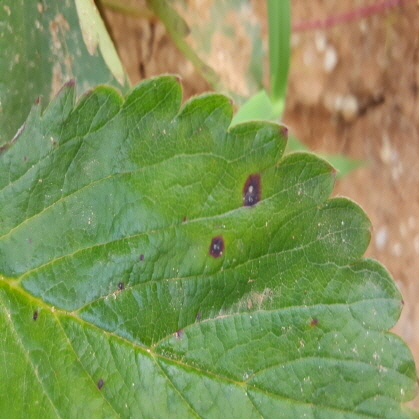

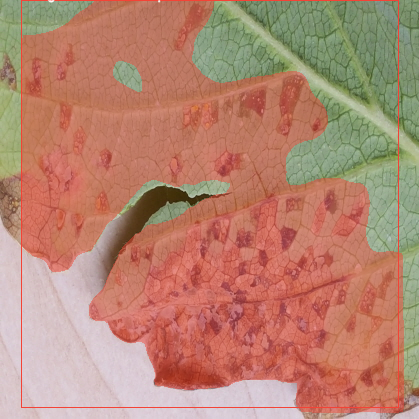

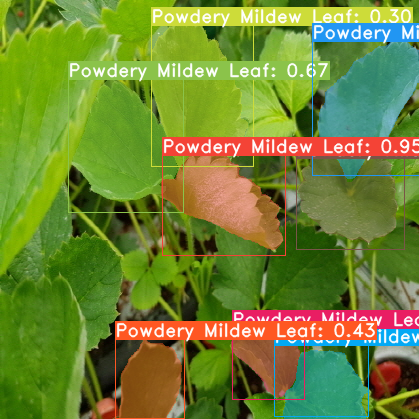

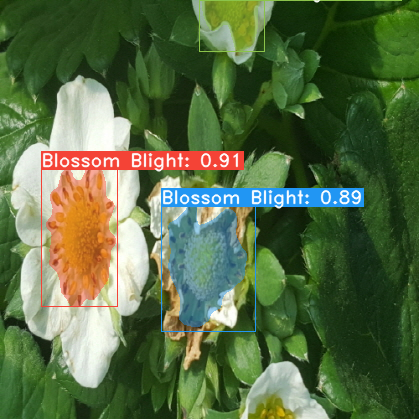

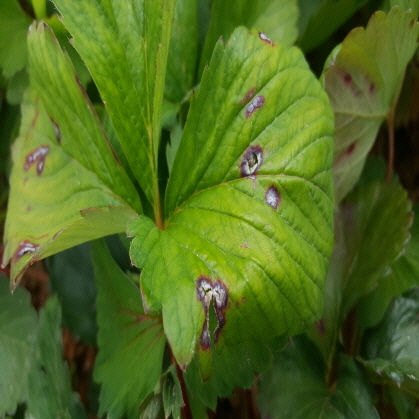

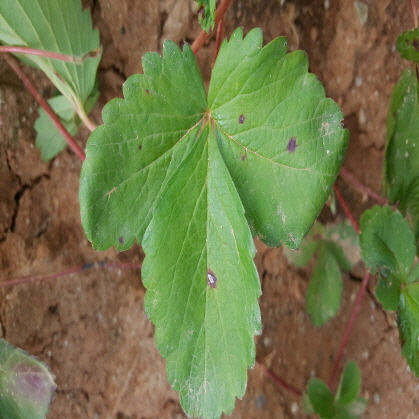

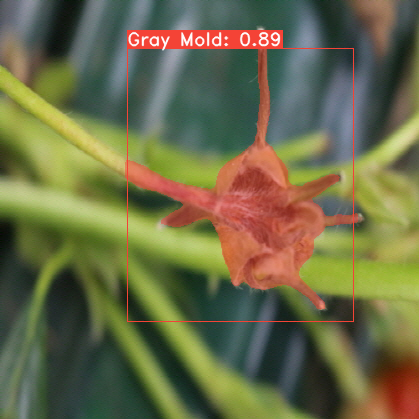

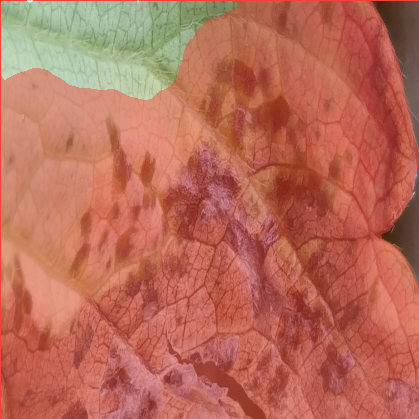

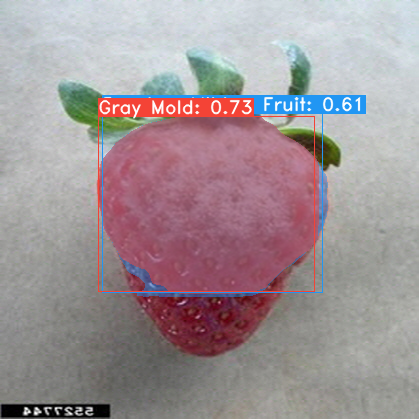

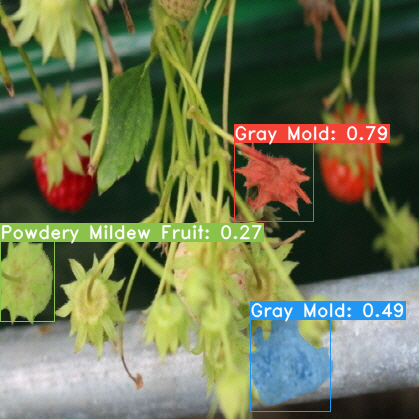

In [66]:
%cd /content
#importa bibliotecas necessarias
from IPython.display import display, Image
import os


cont = 0
for filename in os.listdir("./output_valid_images/"):
  if cont == 10:
    break
  img = Image("./output_valid_images/" + filename)
  display(img)
  print()
  cont += 1
    

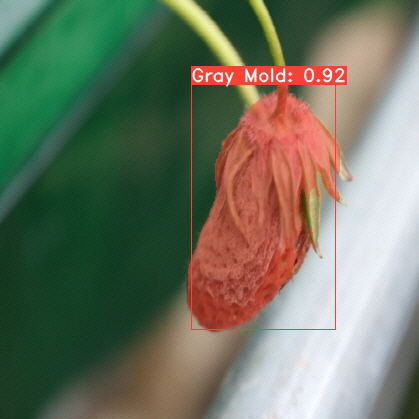

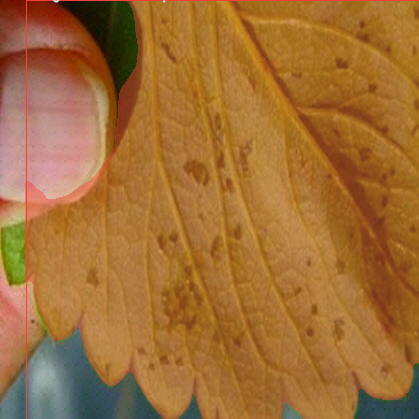

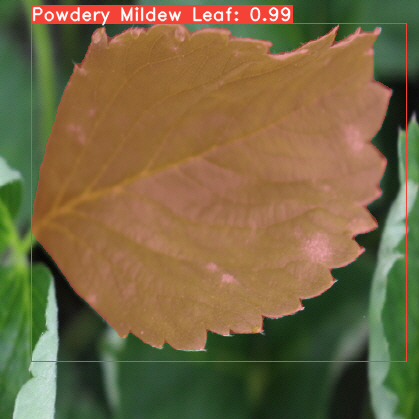

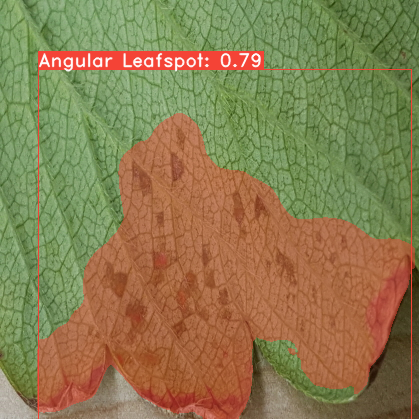

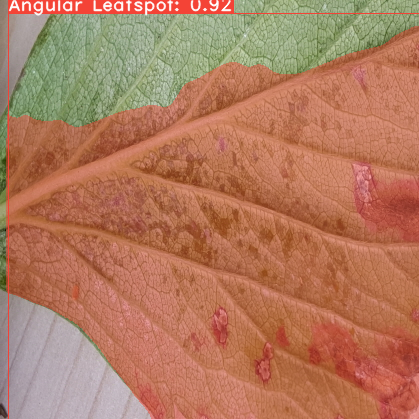

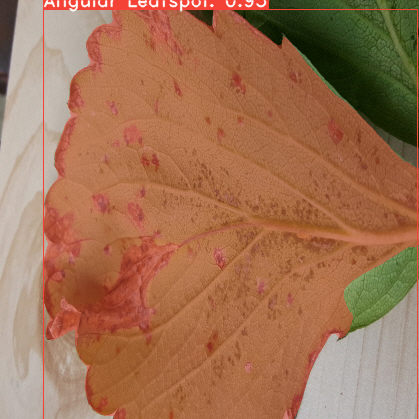

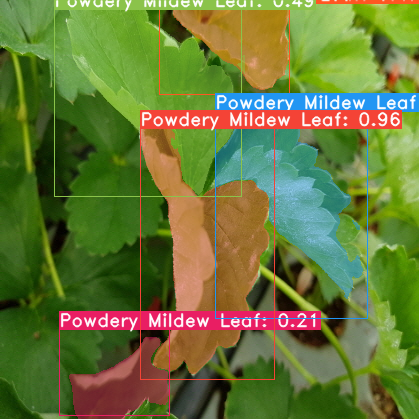

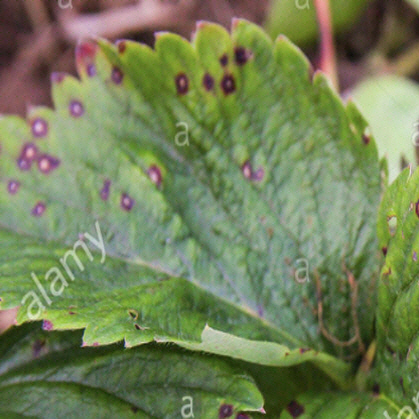

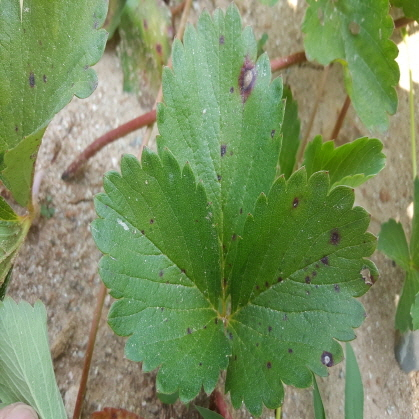

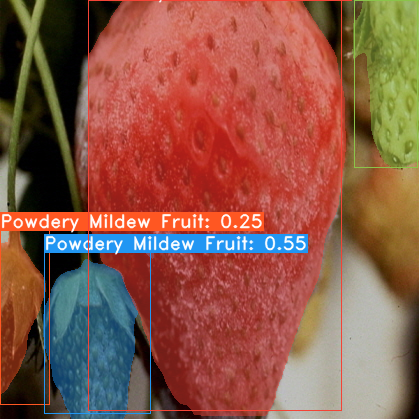

In [67]:
cont = 0
for filename in os.listdir("./output_test_images/"):
  if cont == 10:
    break
  img = Image("./output_test_images/" + filename)
  display(img)
  print()
  cont += 1

## Conclusão:
O modelo possui uma mAP boa para o padrão do modelo YOLACT, porém comparando com os resultados da pesquisa *An Instance Segmentation Model for Strawberry Diseases
Based on Mask R-CNN* ela fica um pouco atrás.
Possíveis causas:
- Não foi utilizado técnicas de augmentation no dataset, e modelos de redes neurais precisam de uma grande quantidade de dados para funcionar perfeitamente.
![Graph-illustrating-the-impact-of-data-available-on-performance-of-traditional-machine.png](https://www.researchgate.net/profile/Benoit-Gallix/publication/324457640/figure/fig1/AS:622298201595905@1525378861825/Graph-illustrating-the-impact-of-data-available-on-performance-of-traditional-machine.png)
- O treinamento não durou tanto tempo quanto o da pesquisa pelas condições de computador, memória, etc.
- Não foi realizado o fine-tuning como foi feito na pesquisa, na qual os pesquisadores mudavam os hiperparametros conforme achavam melhor.
- As condições do backgorund em algumas imagens é ruim pois as fotos foram tiradas com o objetivo de assimilar como seriam tiradas na vida real para um projeto. Algumas não são fotografadas em um meio com luz ou com outras condições para ter uma boa avaliação da imagem. Porém, como disse, o objetivo desse banco de imagens é se aproximar da realidade.

## Referências:
- https://github.com/dbolya/yolact/issues/334
- https://github.com/dbolya/yolact/issues/36
- https://github.com/dbolya/yolact/issues/58
- https://www.immersivelimit.com/tutorials/yolact-with-google-colab

- ## Yolact++
@article{yolact-plus-tpami2020,

  author  = {Daniel Bolya and Chong Zhou and Fanyi Xiao and Yong Jae Lee},

  journal = {IEEE Transactions on Pattern Analysis and Machine Intelligence}, 

  title   = {YOLACT++: Better Real-time Instance Segmentation}, 

  year    = {2020},

}

- ## Dataset
Afzaal, U.; Bhattarai, B.; Pandeya, Y.R.; Lee, J. An Instance Segmentation Model for Strawberry Diseases Based on Mask R-CNN. Sensors 2021, 21, 6565